# Compute Exposed Population

In [3]:
from itertools import product
from datetime import date

import pandas as pd
from tqdm import tqdm

from climada.util import log_level
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.util.coordinates import country_to_iso

from impact_calc import load_hazard, load_worldpop_map, MultiExpImpactCalc

countries = ("ethiopia", "somalia", "sudan")
protection = ("no_protection", "flopros")


def calc_impact(country, intensity):
    # print("Loading hazard")
    hazard = load_hazard(country=country, intensity=intensity)

    # print("Loading exposure")
    exposures_map = load_worldpop_map(country=country)
    # print("Assigning centroids")
    exp = next(iter(exposures_map.values()))
    exp.assign_centroids(hazard)
    for exposure in exposures_map.values():
        exposure.gdf["centr_RF"] = exp.gdf["centr_RF"]
        exposure.gdf["impf_RF"] = 1

    # Impact function
    impf = ImpactFuncSet([ImpactFunc.from_step_impf((0, 0.1, 100), haz_type="RF")])

    # Calculate impact
    impact = MultiExpImpactCalc(
        exposures=exposures_map, impfset=impf, hazard=hazard
    ).impact(save_mat=False, assign_centroids=False)

    return impact


data_events = []
with log_level("ERROR"):
    for ctry, prot in tqdm(
        product(countries, protection), total=len(countries) * len(protection)
    ):
        intensity = "flood_depth" if prot == "no_protection" else "flood_depth_flopros"
        impact = calc_impact(country=ctry, intensity=intensity)
        protection = "No Protection" if prot == "no_protection" else "FLOPROS"
        data_events.append(
            pd.DataFrame.from_records(
                {
                    "People Exposed": impact.at_event,
                    "Year": impact.event_id,
                    "Country": country_to_iso(ctry, "alpha3"),
                    "Protection": protection,
                }
            )
        )

data_events = pd.concat(data_events, ignore_index=True)
data_events

100%|██████████| 6/6 [01:18<00:00, 13.09s/it]


,Country,People Exposed,Protection,Year
0,ETH,4.749083e+05,No Protection,2008
1,ETH,3.663268e+05,No Protection,2009
2,ETH,6.701441e+05,No Protection,2010
3,ETH,4.830026e+05,No Protection,2011
4,ETH,5.646904e+05,No Protection,2012
...,...,...,...,...
85,SDN,2.332376e+05,FLOPROS,2018
86,SDN,3.599764e+06,FLOPROS,2019
87,SDN,4.046095e+06,FLOPROS,2020
88,SDN,7.183878e+05,FLOPROS,2021


/var/folders/fj/w4lbl0pd7l1gcvt664mkfnh00000gq/T/ipykernel_22213/775484309.py:3: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(


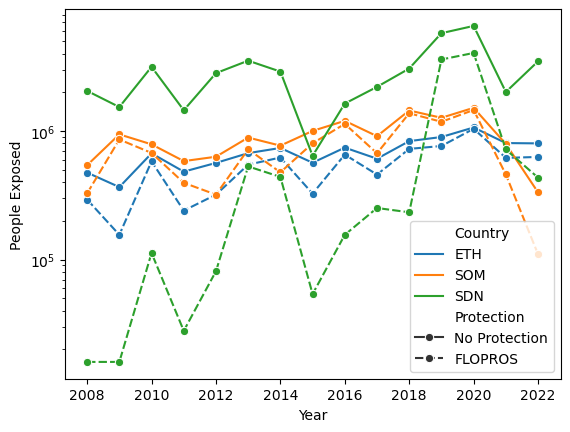

In [6]:
import seaborn as sns

ax = sns.lineplot(
    data=data_events,
    x="Year",
    y="People Exposed",
    hue="Country",
    style="Protection",
    markers="o",
)
ax.set_yscale("log")

In [7]:
data_events.to_csv("exposed_population.csv", index=False)